In [16]:
import cv2
import torch
from PIL import Image
import pandas as pd
import numpy as np
import time


%matplotlib inline

In [2]:
cd Sport-analytics/

C:\Users\Chris\Desktop\Football Analytics\Sport-analytics


In [3]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Chris/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-5-23 torch 1.8.1+cpu CPU



In [10]:
img = cv2.imread('./Images/video1/frame30.jpg', cv2.IMREAD_COLOR)

--- 0.19 seconds ---


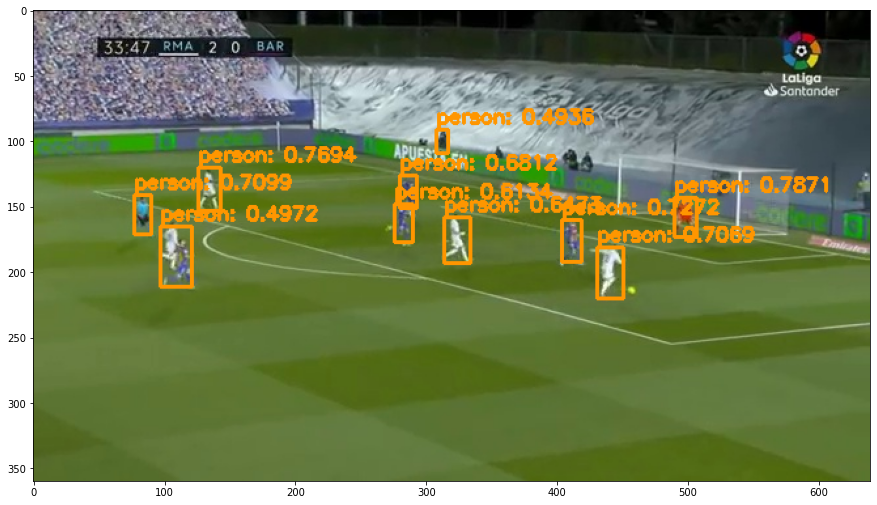

In [21]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

In [ ]:
from PIL import Image
 
def crop(input_file, height, width):
    img = Image.open(input_file)
    img_width, img_height = img.size
    for i in range(img_height//height):
        for j in range(img_width//width):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield img.crop(box)
      
fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 5
ax = []

for i,img in enumerate(crop('./Images/video1/frame30.jpg',100,100)):
    ax.append(fig.add_subplot(rows, columns, i+1))
    plt.title(img.size)
    plt.imshow(img)
    plt.axis('off')

https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

The `stepSize` indicates how many pixels we are going to skip in both the (x, y) direction. 

Normally, we would not want to loop over each and every pixel of the image (i.e. `stepSize`=1) as this would be computationally prohibitive if we were applying an image classifier at each window.

Instead, the `stepSize` is determined on a **per-dataset** basis and is tuned to give optimal performance based on your dataset of images. 

In practice, it’s common to use a `stepSize` of 4 to 8 pixels. 

**Remember, the smaller your step size is, the more windows you’ll need to examine.**

--- 1.50 seconds ---


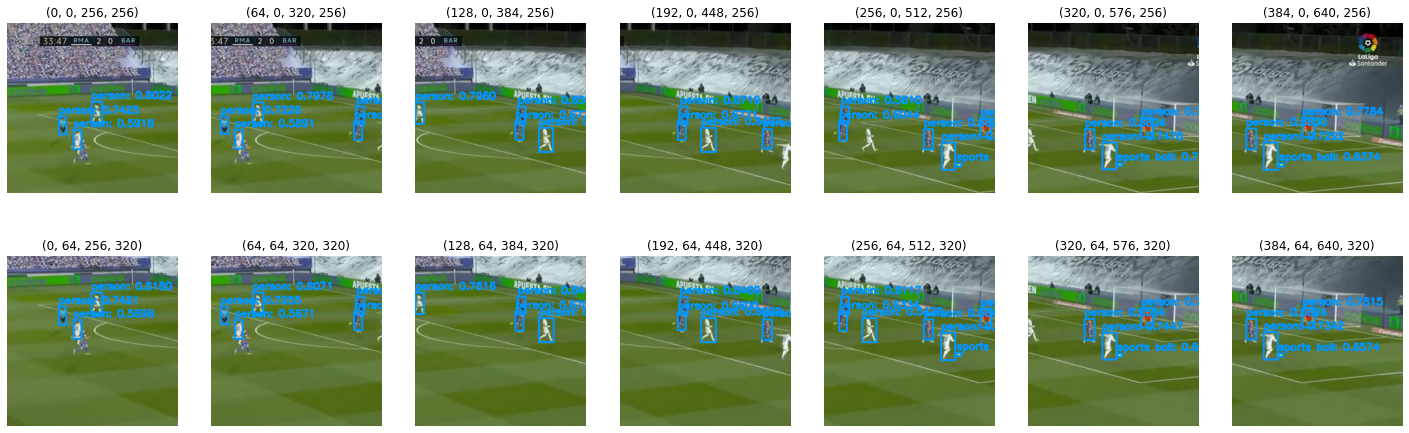

In [25]:
from PIL import Image
import math


def sliding_window(input_file, step_size, window_size):
    img = Image.open(input_file)
    img_width, img_height = img.size
    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, x+window_size[0], y+window_size[1])
            
            if x+window_size[0] <= img_width  and y+window_size[1] <= img_height :
                yield (box, img.crop(box))
                
            
fig = plt.figure(figsize=(25, 25))

img_path = './Images/video1/frame30.jpg'
img = Image.open(img_path)
img_width, img_height = img.size

step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img_path, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
 
    # inference
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plt.title(box)
    plt.imshow(cv2_img_bb)
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
    
## Remove duplicate objects ##    
e = 2

distances = boxes_df.distance.to_list()

for distance in distances:
    first = True

    for index, row in boxes_df.iterrows():
        if first and abs(row.distance-distance) < e:
            first = False
            continue
        else:
            if abs(row.distance-distance) < e:
                boxes_df.drop(index, inplace=True)   
                
                
print("--- %.2f seconds ---" % (time.time() - start_time))

In [13]:
e = 2

distances = boxes_df.distance.to_list()

for distance in distances:
    first = True

    for index, row in boxes_df.iterrows():
        if first and abs(row.distance-distance) < e:
            first = False
            continue
        else:
            if abs(row.distance-distance) < e:
                boxes_df.drop(index, inplace=True)   

In [26]:
boxes_df

,xmin,ymin,xmax,ymax,confidence,class,name,centerx,centery,distance
0,126.493736,119.993309,142.761002,153.308548,0.802243,0,person,134.627369,136.650928,191.828060
1,77.930710,141.068497,89.673004,168.500458,0.742539,0,person,83.801857,154.784477,176.014163
2,99.567154,161.034851,112.398842,190.274719,0.591829,0,person,105.982998,175.654785,205.151162
3,106.428566,178.773285,122.409714,209.703094,0.326003,0,person,114.419140,194.238190,225.433391
6,281.310883,126.679466,293.960358,153.753250,0.635224,0,person,287.635620,140.216358,319.991995
7,278.424561,148.692108,291.094818,177.407288,0.630354,0,person,284.759689,163.049698,328.136076
14,313.226517,158.619125,335.174072,195.041885,0.632232,0,person,324.200294,176.830505,369.289668
19,405.256058,160.309509,419.884857,190.118011,0.648263,0,person,412.570457,175.213760,448.234586
23,418.425491,107.749916,427.905472,123.678894,0.364428,0,person,423.165482,115.714405,438.701320
24,405.682007,106.356369,416.369705,124.207352,0.281563,0,person,411.025856,115.281860,426.886591


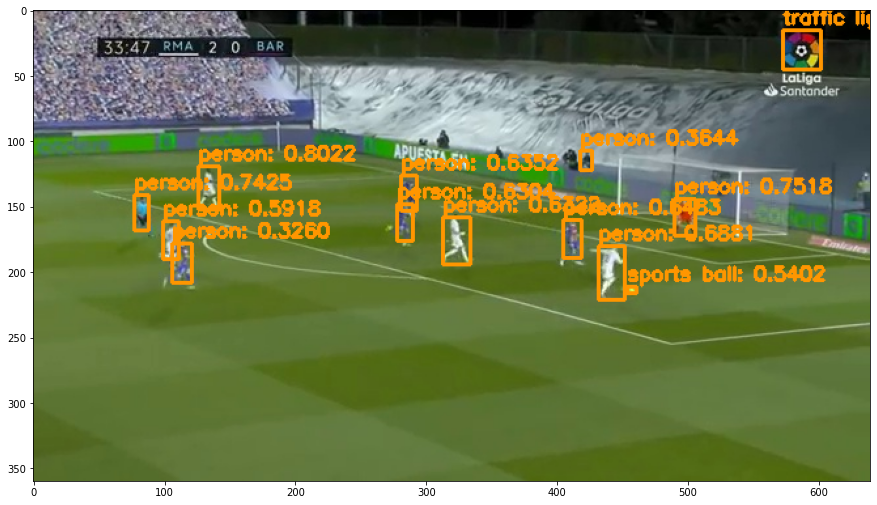

In [28]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

img = cv2.imread('./Images/video1/frame30.jpg', cv2.IMREAD_COLOR)

boxes = boxes_df

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])